In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
!pip install accelerate>=0.20.3

In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


In [4]:
from numpy import vstack
from pandas import read_csv
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import BCELoss
import os


# sklearn (vectorizer, classifier, gridsearch)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt


# For tuning and training
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate


# Auxiliary
from random import shuffle
import pickle
import pandas as pd
import numpy as np
import json
import os
import os.path
import pandas

#### Creating class for inital data struct

In [5]:
# Tagging the data points with positive or negative

class TaggedPoint():
    def __init__(self, data, tag):
        self.data = data
        self.tag = tag

In [6]:
# opens the folder as per my file system and filters data based on rating and screen
# processing it norwegian text

with open("./metadata.json", "r", encoding="utf-8") as file:
    data = json.load(file)
    filtered_data = {k:v for k,v in data.items() if v["category"] == "screen"}

    neg_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [1,2,3]}
    pos_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [5,6]}

print(type(data))
print("Negative reviews: ", len(neg_reviews))
print("Positive reviews: ", len(pos_reviews))


<class 'dict'>
Negative reviews:  5246
Positive reviews:  5166


In [7]:
# count files in directories/csv


# def count_files(path):
#     count = 0
#     for i in os.listdir(path):
#         count += 1
#     print(count)
#     return count


def get_col_len(csv_file):
    df = pd.read_csv(csv_file, dtype={"id":str, "text":str})
    column_lengths = df.astype(str).applymap(len).max()
    print(column_lengths)


# test_count = count_files("./test")
# dev_count = count_files("./dev")
# train_count = count_files("./train")

test_count = get_col_len("./test.csv")
dev_count = get_col_len("./dev.csv")
train_count = get_col_len("./train.csv")

id          6
text    14291
dtype: int64
id          6
text    16178
dtype: int64
id          6
text    22932
dtype: int64


In [8]:
test_df = pd.read_csv("./test.csv", index_col=False, dtype={"id":str, "text":str})
dev_df = pd.read_csv("./dev.csv", index_col=False, dtype={"id":str, "text":str})
train_df = pd.read_csv("./train.csv", index_col=False, dtype={"id":str, "text":str})

#### Change get_files depending on if you are running notebook locally or in colab

In [9]:
# %%time
# # takes the key values in the dictionary items and adds .txt to them for easy comparison in dev, test, train folder
# # by adding the data as TaggedPoint-objects, we can easily reuse many of the supplied functions


# def get_files(path):
#     global neg_reviews, pos_reviews
#     id_neg = [k+".txt" for k in neg_reviews.keys()]
#     id_pos = [k+".txt" for k in pos_reviews.keys()]
#     data = []

#     for file in os.listdir(path):
#         fn = path+file
#         if os.path.isfile(fn):
#             if file in id_neg:
#                 with open(fn, "r", encoding="utf-8") as file:
#                     content = file.read()
#                     data.append(TaggedPoint(content, 0))
#             elif file in id_pos:
#                 with open(fn, "r", encoding="utf-8") as file:
#                     content = file.read()
#                     data.append(TaggedPoint(content, 1))


def get_texts(df):
  global new_reviews, pos_reviews
  id_neg = [k for k in neg_reviews.keys()]
  id_pos = [k for k in pos_reviews.keys()]
  data = []

  for index, row in df.iterrows():
    id = row['id']
    content = row['text']
    if id in id_pos:
      data.append(TaggedPoint(content, 1))
    elif id in id_neg:
      data.append(TaggedPoint(content, 0))

  return data




#     return data # return list with tagged points
# test = get_files("./norec-master/norec-master/data/test/")
# val = get_files("./norec-master/norec-master/data/dev/")
# train = get_files("./norec-master/norec-master/data/train/")

test = get_texts(test_df)
dev = get_texts(dev_df)
train = get_texts(train_df)

print(f"Test set: {len(test)},  Validation set: {len(dev)},  Train set: {len(train)}")


Test set: 1006,  Validation set: 1054,  Train set: 8352


#### Inspecting and choosing padding length

Text(0, 0.5, 'Frquency of words per text')

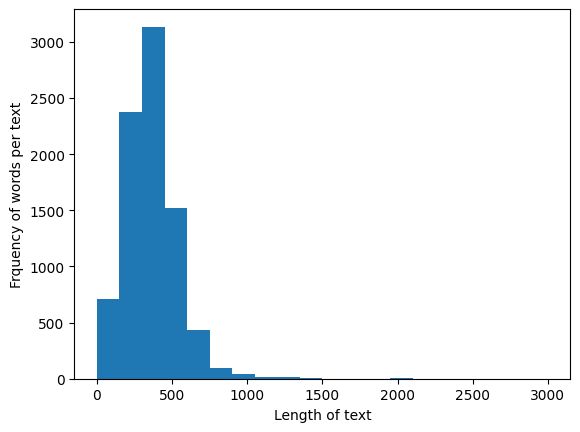

In [10]:

train_lens = [len(i.data.split()) for i in train]
plt.hist(train_lens,
         bins=20,
         range=(0,3000),
         histtype='stepfilled',)
plt.xlabel("Length of text")
plt.ylabel("Frquency of words per text")

#### Creating the datasets used in training of the BERT and baseline model

In [11]:
from datasets import Dataset
# to rnsure that the model has not memorized any patterns
def shuffle_split(test, val, train):
    shuffle(test)
    shuffle(val)
    shuffle(train)
    return test, val, train


test_set, dev_set, train_set = shuffle_split(test, dev, train)
print("1: ", type(test_set), type(dev_set), type(train_set))
#print(test_set)


def dictify(li):
    data = {"label":[], "text":[]}
    for item in li:
        data["label"].append(item.tag)
        data["text"].append(str(item.data))
    return data


test_set = dictify(test_set)
dev_set = dictify(dev_set)
train_set = dictify(train_set)
print("2: ", type(test_set), type(dev_set), type(train_set))


test_set = Dataset.from_dict(test_set)
dev_set = Dataset.from_dict(dev_set)
train_set = Dataset.from_dict(train_set)
print("3: ", type(test_set), type(dev_set), type(train_set))
print(test_set)
print(dev_set)
print(train_set)

1:  <class 'list'> <class 'list'> <class 'list'>
2:  <class 'dict'> <class 'dict'> <class 'dict'>
3:  <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['label', 'text'],
    num_rows: 1006
})
Dataset({
    features: ['label', 'text'],
    num_rows: 1054
})
Dataset({
    features: ['label', 'text'],
    num_rows: 8352
})


#### Creating dataset for unlabeled data

In [12]:
with open("./unlab_metadata.json", "r") as f:
    metadata = json.load(f)

print(len(metadata))

382


In [13]:
unlabelled_df = pd.read_csv("./unlab.csv", index_col=False, dtype={"id":str, "text":str})
unlabelled_df.head()

,id,text
0,20050421-1,nei til sameflagg 17. mai \net flertall i osl...
1,20050424-1,si! ja! i will! \nog så fikk gørild mauseth s...
2,20050430-1,reinsdyrpeniser blir sexpulver for asiater \n...
3,20050524-1,en god lov for finnmark \net flertall i stort...
4,20050524-2,frykter storstilt privatisering \nhammerfest ...


In [14]:

# def get_unlabelled_data(path_test, path_metadata):
#     data = {"id":[], "year":[], "label":[], "text":[], "paper":[]}

#     with open(path_metadata, "r", encoding="utf-8") as metafile:
#         metadata = json.load(metafile)


#     for fn, fd in metadata.items():

#         year = fd["year"].replace("test_", "")
#         paper = fd["paper"].replace("test_", "")

#         fp = f"{path_test}/{fn}.txt"
#         with open(fp, "r", encoding="utf-8") as tf:
#             text = tf.read().strip()

#         data["id"].append(fn)
#         data["year"].append(year)
#         data["label"].append(None)
#         data["text"].append(text)
#         data["paper"].append(paper)
#     return data


def get_unlabelled_data(df, path_metadata):
  data = {"id":[], "year":[], "label":[], "text":[], "paper":[]}

  with open(path_metadata, "r", encoding="utf-8") as metafile:
    metadata = json.load(metafile)



  for fn, fd in metadata.items():
    year = fd["year"].replace("test_", "")
    paper = fd["paper"].replace("test_", "")

    text_row = df[df['id'] == fn]
    if not text_row.empty:
      text = text_row['text'].iloc[0]
      data["id"].append(fn)
      data["year"].append(year)
      data["label"].append(None)
      data["text"].append(text)
      data["paper"].append(paper)
  return data


unlabelled_data = get_unlabelled_data(unlabelled_df, "./unlab_metadata.json")
unlabelled_data = Dataset.from_dict(unlabelled_data)
print(unlabelled_data)
# for k,v in unlabelled_data.items():
#     print(k,v, "\n")


Dataset({
    features: ['id', 'year', 'label', 'text', 'paper'],
    num_rows: 382
})


## Making a baseline model

In [15]:
# function that returns train features and feautres for both tfidf and countvectorizer

def get_train_features(train):
    #initialize vectorizer
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform([review.data for review in train])

    y_train = np.array([review.tag for review in train])

    return vectorizer, X_train, y_train



def get_features(data_set, vectorizer):

    X = vectorizer.transform([review.data for review in data_set])

    y = np.array([review.tag for review in data_set])

    return X, y


def get_secondary_features(data_set, vectorizer):
    # Note that we conscider another structure for the unlabelled test data

    X = vectorizer.transform([text for text in data_set["text"]])

    return X

In [16]:
# in order to maximize the performance of our logreg model, we use grid search to find the best params

def grid_search(X, y):
    #initialize our model
    lr = LogisticRegression(max_iter=1500)

    #create a grid of different parameters to try out during the search
    parameters = {
        # sag doesn't support "l1" -> warning
        "penalty": [None, "l1", "l2"],
        "tol": [1e-4, 1.5e-4 ,2e-4],
        "class_weight": [None, "balanced"],
        "random_state": [0, 42], #, 1337],
        "solver": ["lbfgs", "sag" ,"saga", "liblinear"],
        }


    clf = GridSearchCV(lr, parameters, verbose=2) # use n_jobs=6 locally
    clf.fit(X, y)
    return clf

def print_info(grid_result):
    print(grid_result)
    for p in grid_result.param_grid:
        print("\033[92m%20s \033[93m%-12s\033[0m %s" %
        (p, grid_result.best_params_[p], grid_result.param_grid[p]))

In [17]:
# tuning-function that takes the params and training- and validation sets to give the result
# returns the classifier obejct along with displaying a matrix

def make_best(params, X_train, y_train, X_val, y_val):
    lr = LogisticRegression(max_iter=1500,
                            penalty=params["penalty"],
                            class_weight=params["class_weight"],
                            random_state=params["random_state"],
                            solver=params["solver"],
                            tol=params["tol"],
                            )

    clf = lr.fit(X_train, y_train)

    print(clf.classes_)
    predictions = clf.predict(X_val)
    # print(predictions)

    print('\n\033[94mConfusion matrix:\033[0m\n',
          confusion_matrix(y_val, predictions, labels=[0, 1]))
    print(classification_report(y_val, predictions))

    cm = confusion_matrix(y_val, predictions, labels=[0,1])
    fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    fig.plot(ax=plt.gca(), cmap="plasma")

    plt.show()

    return clf

#### Extracting features for TF-IDF

In [18]:
# Extracting transformed features and vectorizer

vectorizer, X_train, y_train = get_train_features(train)
X_dev, y_dev = get_features(dev, vectorizer)
X_test, y_test = get_features(test, vectorizer)

In [19]:
# Checking if shape is properly set

print("Train set shape: ", X_train.shape, y_train.shape, "\nTest set shape: ",  X_test.shape, y_test.shape)

Train set shape:  (8352, 151073) (8352,) 
Test set shape:  (1006, 151073) (1006,)


#### Running grid_search

In [20]:
%%time

grid_result = grid_search(X_train, y_train)
print_info(grid_result)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.0001; total time=   2.6s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.0001; total time=   1.4s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.0001; total time=   1.9s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.0001; total time=   2.1s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.0001; total time=   1.8s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.00015; total time=   2.2s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.00015; total time=   1.9s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.00015; total time=   2.8s
[CV] END class_weight=None, penalty=None, random_state=0, solver=lbfgs, tol=0.00015; total time=   2.2s
[CV] E

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

GridSearchCV(estimator=LogisticRegression(max_iter=1500),
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['lbfgs', 'sag', 'saga', 'liblinear'],
                         'tol': [0.0001, 0.00015, 0.0002]},
             verbose=2)
             penalty None         [None, 'l1', 'l2']
                 tol 0.00015      [0.0001, 0.00015, 0.0002]
        class_weight None         [None, 'balanced']
        random_state 0            [0, 42]
              solver lbfgs        ['lbfgs', 'sag', 'saga', 'liblinear']
CPU times: user 1h, sys: 34min 6s, total: 1h 34min 7s
Wall time: 54min 25s


[0 1]

Confusion matrix:
 [[452  69]
 [ 49 484]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       521
           1       0.88      0.91      0.89       533

    accuracy                           0.89      1054
   macro avg       0.89      0.89      0.89      1054
weighted avg       0.89      0.89      0.89      1054



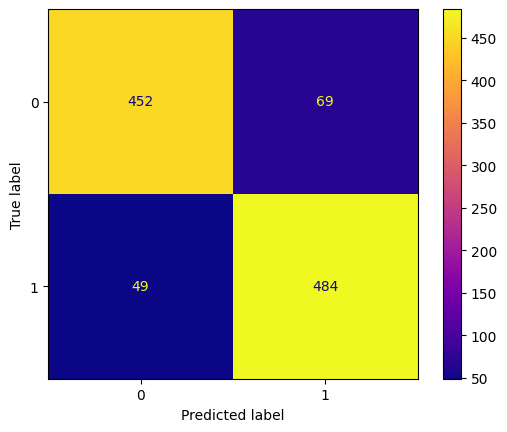

CPU times: user 6.16 s, sys: 24 s, total: 30.2 s
Wall time: 2.83 s


In [21]:
%%time

best_classifier = make_best(grid_result.best_params_, X_train, y_train, X_dev, y_dev)

In [22]:
print(grid_result.best_params_)
print(type(best_classifier))

{'class_weight': None, 'penalty': None, 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.00015}
<class 'sklearn.linear_model._logistic.LogisticRegression'>


#### Saving model incase of notebook failure

> Only run if file not created, else you will overwrite


In [23]:
fp = "./baseline.pkl"
with open(fp, "wb") as f:
    pickle.dump(best_classifier, f)


In [24]:
fp = "./baseline.pkl"
with open(fp, "rb") as f:
    loaded_model = pickle.load(f)


print(loaded_model)

LogisticRegression(max_iter=1500, penalty=None, random_state=0, tol=0.00015)


#### Making predictions on unlabelled data

In [25]:
X_unlabelled = get_secondary_features(unlabelled_data, vectorizer)

In [26]:
predictions = loaded_model.predict(X_unlabelled)

In [27]:
print(predictions)
print(len(predictions))
baseline_data = unlabelled_data

print(baseline_data)
baseline_data = baseline_data.remove_columns("label")
baseline_data = baseline_data.add_column("label", predictions)

print(baseline_data["label"])


[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1
 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1
 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0
 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 0]
382
Dataset({
    features: ['id', 'year', 'label', 'text', 'paper'],
    num_rows: 382
})
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 

In [28]:
#### Random control samples for the dataset


In [29]:
import random

sample = random.sample(range(len(predictions)), 5)


In [30]:
# We will extract 5 random samples. The samples will be saved so we can see if the bert model classifies similarily
print("Randomly chosen list indices: ", sample)
baseline_sample = []
for n in sample:
  baseline_sample.append(baseline_data["label"][n])
print("Randomly chosen predications: ", baseline_sample)
eval_list = list(zip(baseline_data["label"], baseline_data["text"]))

for s in sample:
    if eval_list[s][0] == 1:
        temp = "Positive / 1"
    else:
      temp = "Negative / 0"
    print("-"*30)
    print(f"This text have been classified as: {temp}\n\n")
    print(eval_list[s][1], "\n")


Randomly chosen list indices:  [78, 27, 22, 64, 60]
Randomly chosen predications:  [1, 1, 1, 1, 1]
------------------------------
This text have been classified as: Positive / 1


fanget rein med bare nevene  gjennom bilvindu  
vg nett et løpsk reinsdyr skapte kaos på riksveien i finnmark. men
konstituert lensmann klemet klemetsen visste råd.
av mats bleikelia  
trafikkfarlig reinsdyr som forviller seg ut på veiene, kan utgjøre
stor fare for bilister. reinen på bildet er ikke den samme som omtales
i artikkelen. illustrasjonsfoto dag fonbækvg        en noe uvanlig biljakt
fant sted på riksveien mellom bredbuktnes og kautokeino i går.
et løpsk reinsdyr med løshunder i hælene forvillet seg ut på asfaltdekket
og satte full fart i retning kautokeino. flere bilister måtte  gjøre
brå unnamanøvre for å unngå kollisjon med den forvirrede reinen, skriver
altaposten.
da det lokale politikontoret fikk melding om hendelsen, kastet klemetsen
seg i tjenestebilen og tok opp jakten.
 jeg påtraff reinen

<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['id', 'year', 'text', 'paper', 'label'],
    num_rows: 382
})


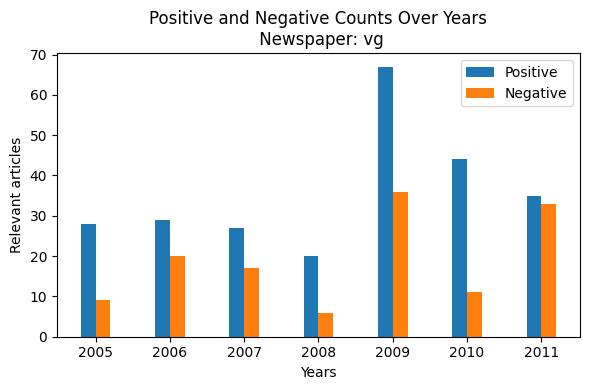

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

print(type(baseline_data))


def plot_model(data, paper):
    plot = {}
    print(data)
    filtered_data = [item for item in data if item["paper"] == paper]
    years = set(sorted(int(item["year"]) for item in filtered_data))
    for y in years:
        plot[y] = {"pos":0, "neg":0}

    for d in filtered_data:
        if int(d["year"]) in plot:
            if d["label"] == 1:
                plot[int(d["year"])]["pos"] += 1
            elif d["label"] == 0:
                plot[int(d["year"])]["neg"] += 1



    sorted_data = dict(sorted(plot.items()))
    years = list(sorted_data.keys())
    pos_values = [sorted_data[year]['pos'] for year in years]
    neg_values = [sorted_data[year]['neg'] for year in years]
    bar_width = 0.2
    index = np.arange(len(years))

    plt.figure(figsize=(6, 4))

    bar1 = plt.bar(index, pos_values, bar_width, label='Positive')
    bar2 = plt.bar(index + bar_width, neg_values, bar_width, label='Negative')

    plt.xlabel('Years')
    plt.ylabel('Relevant articles')
    plt.title(f'Positive and Negative Counts Over Years\n Newspaper: {paper}')
    plt.xticks(index + bar_width / 2, years)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_model(baseline_data, "vg")

## Creating a BERT model for classification

#### Loading BERT and tokenizer

In [33]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("ltg/norbert3-small")
model = AutoModelForMaskedLM.from_pretrained("ltg/norbert3-small", trust_remote_code=True)

mask_id = tokenizer.convert_tokens_to_ids("[MASK]")
input_text = tokenizer("Norske samer er[MASK] personer.", return_tensors="pt")
output_p = model(**input_text)
output_text = torch.where(input_text.input_ids == mask_id, output_p.logits.argmax(-1), input_text.input_ids)

print(tokenizer.decode(output_text[0].tolist()))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

configuration_norbert.py:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ltg/norbert3-small:
- configuration_norbert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_norbert.py:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ltg/norbert3-small:
- modeling_norbert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/188M [00:00<?, ?B/s]

[CLS] Norske samer er norske personer.[SEP]


In [34]:
print(model.classifier)


MaskClassifier(
  (nonlinearity): Sequential(
    (0): LayerNorm((384,), eps=1e-07, elementwise_affine=False)
    (1): Linear(in_features=384, out_features=384, bias=True)
    (2): GELU(approximate='none')
    (3): LayerNorm((384,), eps=1e-07, elementwise_affine=False)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=384, out_features=50000, bias=True)
  )
)


In [35]:
# checkpoint for NorBERT location
checkpoint = "ltg/norbert3-small"

# adding autotokenizer from huggingface to bert model
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)


# manually adding binary classification configuration
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}


#bert = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True)
bert = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label=id2label, label2id=label2id, trust_remote_code=True)



# tokenizing function on all text fields in tagged points' text
def tokenize_function(tp):
    text = tp["text"]

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        padding="max_length",
        return_tensors="np",
        truncation=True,
        max_length=512,
        )
    return tokenized_inputs



In [36]:

# adding special padding tokens where data is missing
# the model knoes that [PAD] does not carry any semantic meaning and is to be ignored
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token":"[PAD]"})
    bert.resize_token_embeddings(len(tokenizer))


test_nn = test_set.map(tokenize_function, batched=True)
dev_nn = dev_set.map(tokenize_function, batched=True)
train_nn = train_set.map(tokenize_function, batched=True)
unlab_pred_nn = unlabelled_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/8352 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

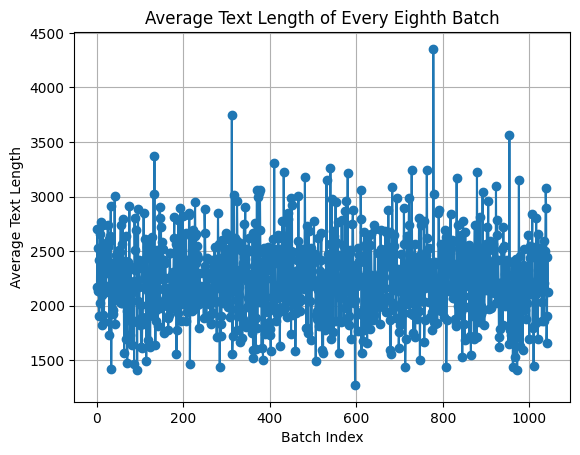

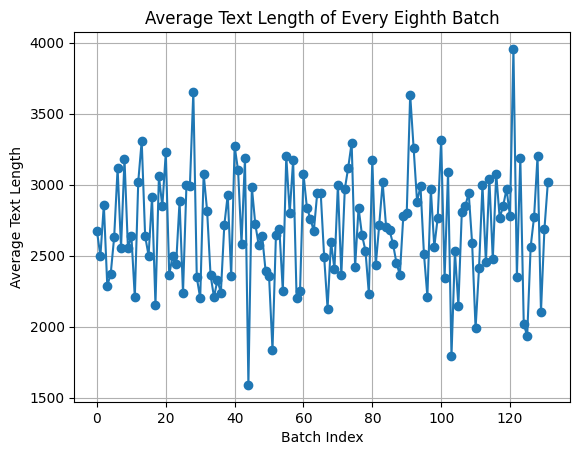

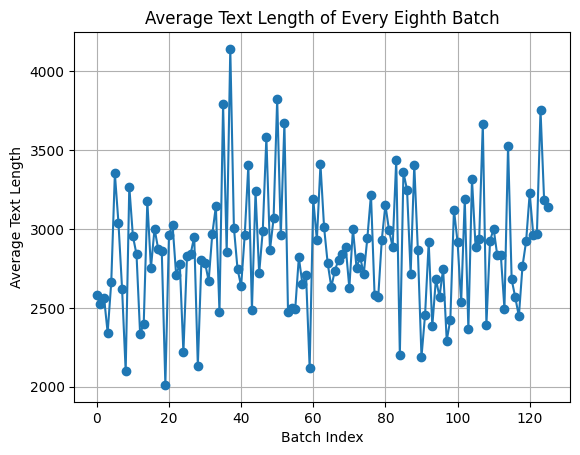

In [73]:

def create_batch_plot(dataset):
  text_lengths = [len(text) for i, text in enumerate(dataset)]

  average_lengths = []
  batch_indices = []
  for i in range(0, len(text_lengths), 8):
      batch_lengths = text_lengths[i:i+8]
      average_length = sum(batch_lengths) / len(batch_lengths)
      average_lengths.append(average_length)
      batch_indices.append(i//8)

  plt.plot(batch_indices, average_lengths, marker='o', linestyle='-')
  plt.title('Average Text Length of Every Eighth Batch')
  plt.xlabel('Batch Index')
  plt.ylabel('Average Text Length')
  plt.grid(True)
  plt.show()

create_batch_plot(train_set["text"])
create_batch_plot(dev_set["text"])
create_batch_plot(test_set["text"])

In [37]:
class CustomClassifierHead(torch.nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.dropout = torch.nn.Dropout(0.05)
        self.norm = torch.nn.LayerNorm(input_dim, eps=1e-07, elementwise_affine=False)
        self.linear = torch.nn.Linear(input_dim, num_labels)
        self.gelu_activation = torch.nn.GELU()

    def forward(self, x):
        x = self.dropout(x)
        x = self.norm(x)
        x = self.gelu_activation(x)
        x = self.linear(x)
        return x


model.classifier = CustomClassifierHead(model.config.hidden_size, num_labels=2)  # Assuming binary classification


In [38]:
print(model.classifier)

CustomClassifierHead(
  (dropout): Dropout(p=0.05, inplace=False)
  (norm): LayerNorm((384,), eps=1e-07, elementwise_affine=False)
  (linear): Linear(in_features=384, out_features=2, bias=True)
  (gelu_activation): GELU(approximate='none')
)


In [39]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels)



batch_size = 8
number_of_epochs = 5
logging_steps = len(train_nn) // batch_size



training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=number_of_epochs,
    logging_steps=logging_steps,
    save_steps=1000,
    eval_steps=500,

    )


trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_nn,
    eval_dataset=dev_nn,
    compute_metrics=compute_metrics,
    data_collator=data_collator

)

In [40]:
%%time

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.406800,0.207080,0.930740,0.929740,0.954545,0.906191
2,0.186600,0.245075,0.944023,0.943863,0.957529,0.930582
3,0.091400,0.278394,0.947818,0.948454,0.947566,0.949343
4,0.026000,0.339227,0.944972,0.946097,0.937385,0.954972
5,0.009700,0.396577,0.944972,0.945386,0.948960,0.941839


CPU times: user 11min 21s, sys: 6.18 s, total: 11min 27s
Wall time: 11min 25s


TrainOutput(global_step=5220, training_loss=0.1440996310720042, metrics={'train_runtime': 684.9759, 'train_samples_per_second': 60.966, 'train_steps_per_second': 7.621, 'total_flos': 2749810705367040.0, 'train_loss': 0.1440996310720042, 'epoch': 5.0})

In [41]:
test_results = trainer.evaluate(eval_dataset=test_nn)

print("Test Set Evaluation:")
for key, value in test_results.items():
    print(f"{key}: {value}")

Test Set Evaluation:
eval_loss: 0.39732825756073
eval_accuracy: 0.941351888667992
eval_f1: 0.9465095194922938
eval_precision: 0.9473684210526315
eval_recall: 0.9456521739130435
eval_runtime: 4.9018
eval_samples_per_second: 205.23
eval_steps_per_second: 25.705
epoch: 5.0


In [87]:
print(test_nn)
test_nn_prediction = get_pred_from_bert(device, trainer, tokenize_function_alt, test_nn["text"])
dev_nn_prediction = get_pred_from_bert(device, trainer, tokenize_function_alt, dev_nn["text"])

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1006
})



Confusion matrix:
 [[494  27]
 [ 31 502]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       521
           1       0.95      0.94      0.95       533

    accuracy                           0.94      1054
   macro avg       0.94      0.95      0.94      1054
weighted avg       0.95      0.94      0.94      1054



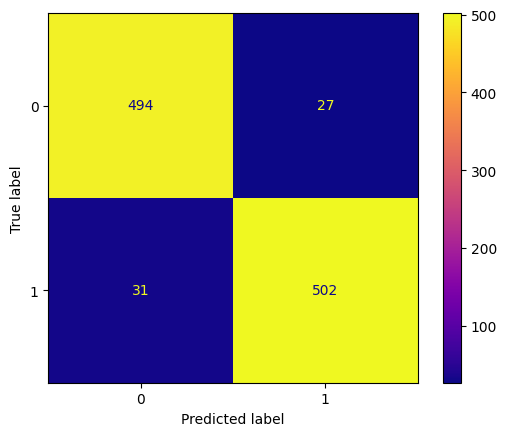

In [88]:
def make_cf(y_val, predictions):
    print('\n\033[94mConfusion matrix:\033[0m\n', confusion_matrix(y_val, predictions, labels=[0, 1]))
    print(classification_report(y_val, predictions))

    cm = confusion_matrix(y_val, predictions, labels=[0,1])
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(ax=ax, cmap="plasma")
    plt.show()

make_cf(dev_nn["label"], dev_nn_prediction)

### Predicting labels for unlabelled data

In [42]:
print(unlab_pred_nn)
print(test_nn)
unlab_pred_nn_ = unlab_pred_nn.remove_columns(["id", "year", "paper"])


Dataset({
    features: ['id', 'year', 'label', 'text', 'paper', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 382
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1006
})


In [43]:
def tokenize_function_alt(text):
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        padding="max_length",
        return_tensors="pt",
        truncation=True,
        max_length=512,
        )
    return tokenized_inputs

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = trainer.model.to(device)


In [45]:
def get_pred_from_bert(device, trainer, func, dataset):
    labels = []
    class_names = [0, 1]

    for text in dataset:
        encoded = func(text)
        id = encoded["input_ids"].to(device)
        at = encoded["attention_mask"].to(device)
        op = trainer.model(id, at)
        _, prediction = torch.max(op.logits, dim=1)
        labels.append(class_names[prediction])

    return labels

predictions = get_pred_from_bert(device, trainer, tokenize_function_alt, unlab_pred_nn_["text"])


In [47]:
unlab_pred_nn = unlab_pred_nn.remove_columns(["label"])
unlab_pred_nn = unlab_pred_nn.add_column("label", predictions)


### Comparing

Dataset({
    features: ['id', 'year', 'text', 'paper', 'label'],
    num_rows: 382
})


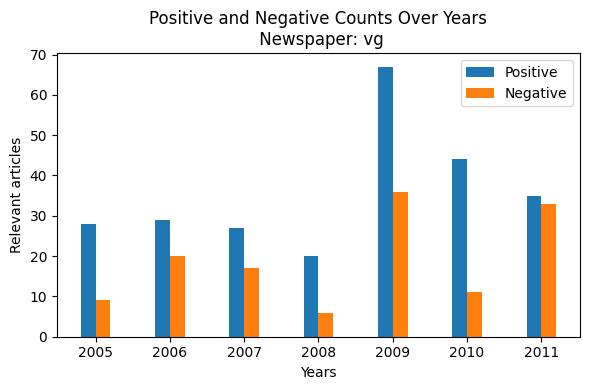

In [48]:
plot_model(baseline_data, "vg")

Dataset({
    features: ['id', 'year', 'text', 'paper', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 382
})


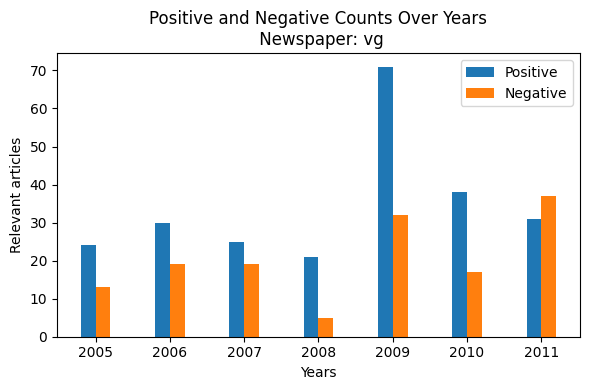

In [49]:
plot_model(unlab_pred_nn, "vg")

In [50]:
sample_nn = sample
print(sample_nn)

[78, 27, 22, 64, 60]


In [51]:
eval_list_nn = list(zip(unlab_pred_nn["label"], unlab_pred_nn["text"]))
print("Randomly chosen list indices: ", sample)
unlab_sample = []
for n in sample:
  unlab_sample.append(unlab_pred_nn["label"][n])
print("Randomly chosen predications: ", unlab_sample)

for s in sample:
    if eval_list_nn[s][0] == 1:
        temp = "Positive / 1"
    else:
        temp = "negative / 0"
    print("-"*30)
    print(f"This text have been classified as: {temp}\n\n")
    print(eval_list_nn[s][1], "\n")


Randomly chosen list indices:  [78, 27, 22, 64, 60]
Randomly chosen predications:  [1, 1, 1, 0, 1]
------------------------------
This text have been classified as: Positive / 1


fanget rein med bare nevene  gjennom bilvindu  
vg nett et løpsk reinsdyr skapte kaos på riksveien i finnmark. men
konstituert lensmann klemet klemetsen visste råd.
av mats bleikelia  
trafikkfarlig reinsdyr som forviller seg ut på veiene, kan utgjøre
stor fare for bilister. reinen på bildet er ikke den samme som omtales
i artikkelen. illustrasjonsfoto dag fonbækvg        en noe uvanlig biljakt
fant sted på riksveien mellom bredbuktnes og kautokeino i går.
et løpsk reinsdyr med løshunder i hælene forvillet seg ut på asfaltdekket
og satte full fart i retning kautokeino. flere bilister måtte  gjøre
brå unnamanøvre for å unngå kollisjon med den forvirrede reinen, skriver
altaposten.
da det lokale politikontoret fikk melding om hendelsen, kastet klemetsen
seg i tjenestebilen og tok opp jakten.
 jeg påtraff reinen

In [53]:
def count_different_values(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("The input lists must have the same length.")

    count = 0
    for i in range(len(list1)):
        if list1["label"][i] != list2["label"][i]:
            count += 1

    return count

# This is how to predict with unlabelled data
result = count_different_values(unlab_pred_nn, baseline_data)
print("Number of different values:", result)

Number of different values: 102


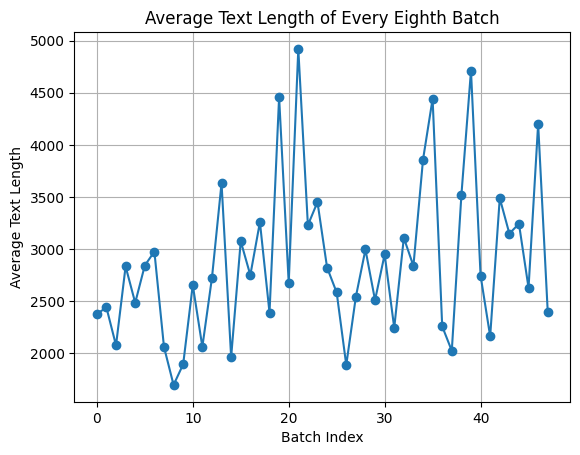

In [74]:
create_batch_plot(unlabelled_data["text"])

### Saving incase of failure/for later use

In [ ]:
trainer.save_model("./bert_ft")

In [ ]:

# !zip -r /content/file.zip /content/bert_ft

# from google.colab import files
# files.download("/content/file.zip")